# CZII - CryoET Object Identification

## Import

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import neighbors
import torch
from torch import nn
import torch.nn.functional as functional
import copy
from matplotlib import cm
from matplotlib.colors import Normalize
import open3d as o3d
from torch.utils.data import Dataset, DataLoader
import json
import time
from matplotlib.lines import Line2D
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


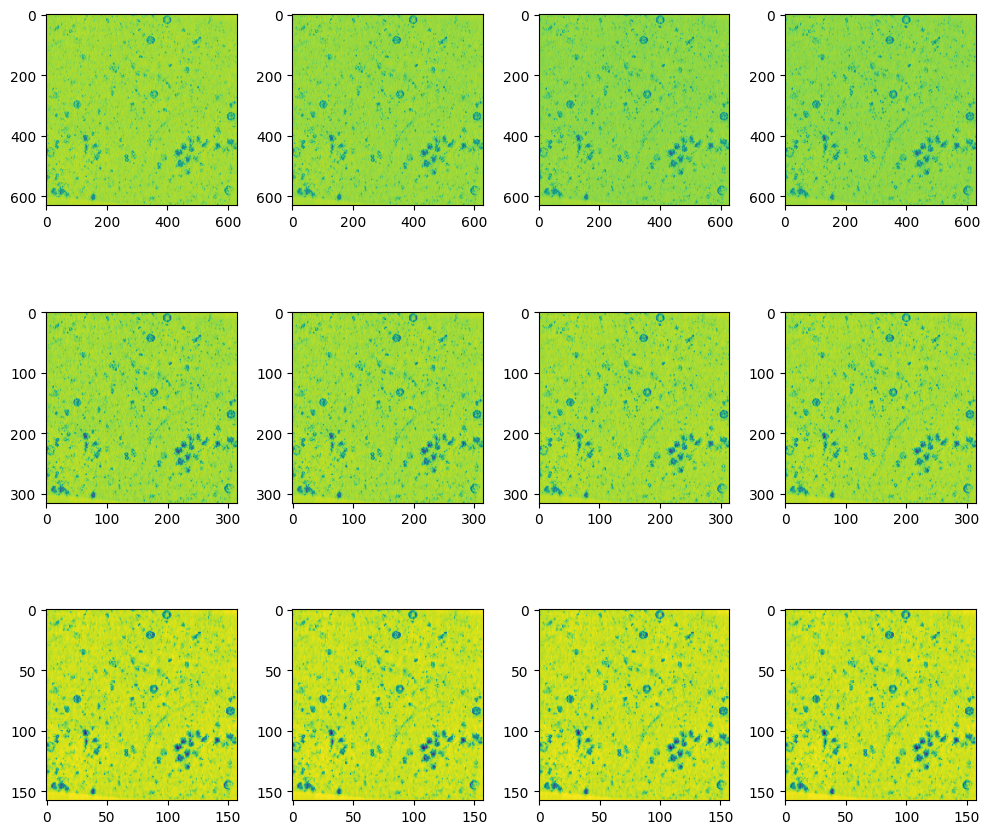

In [579]:
experiment_run = 'TS_86_3'
z1 = hig_res_dataset[experiment_run]
fig = plt.figure(figsize=(10,10))

start = 60
n_imgs = 4
for i in range(z1.shape[0]):
    if i < start:
        continue
    if i > start + n_imgs-1:
        break
    ax = plt.subplot(3, n_imgs, i-start+1)
    _ = plt.imshow(hig_res_dataset[experiment_run][i, :, :])
    # plt.colorbar()
    ax = plt.subplot(3, n_imgs, i-start+1+n_imgs)
    _ = plt.imshow(med_res_dataset[experiment_run][i//2, :, :])
    # plt.colorbar()
    ax = plt.subplot(3, n_imgs, i-start+1+n_imgs*2)
    _ = plt.imshow(low_res_dataset[experiment_run][i//4, :, :])
    # plt.colorbar()
    plt.tight_layout()


### Plotting images with point of interest

In [580]:
def mark_particle_on_image(img, hit):
    fig = plt.figure(figsize=(10,10))
    colors_particle = {'beta-galactosidase': 'red', 'thyroglobulin': 'blue', 'apo-ferritin': 'magenta', 'ribosome': 'red', 'beta-amylase': 'blue', 'virus-like-particle': 'magenta'}
    markers_particle = {'beta-galactosidase': 's', 'thyroglobulin': 's', 'apo-ferritin': 's', 'ribosome': 'o', 'beta-amylase': 'o', 'virus-like-particle': 'o'}
    legend_handle = []
    for particle in colors_particle.keys():
        legend_handle.append(Line2D([0], [0], color=colors_particle[particle], marker=markers_particle[particle], label=particle, markersize=5, linestyle='none'))
    ax = plt.subplot(1, 2, 1)
    _ = plt.imshow(img)
    ax = plt.subplot(1, 2, 2)
    _ = plt.imshow(img)
    for j, coord in enumerate(hit['coord']):
        plt.scatter(coord[0], coord[1], marker=markers_particle[hit['labels'][j]], edgecolors=colors_particle[hit['labels'][j]], facecolors='none', s = 20, label=(hit['labels'][j]))
        plt.legend(handles=legend_handle, bbox_to_anchor=(1, 1))

t: [243.11759999999998, 576.0391999999999]; r: [61.655899999999995, 588.3402]; b: [213.25349999999997, 266.15819999999997]; a: [158.4637, 45.4698]; v: [601.3231, 187.1433]; t: [49.285700000000006, 79.8312]; b: [156.7122, 213.10790000000003]; b: [464.0, 186.5]; v: [515.7398000000001, 444.1079]; v: [476.558, 346.9964]; t: [243.11759999999998, 576.0391999999999]; r: [61.655899999999995, 588.3402]; b: [213.25349999999997, 266.15819999999997]; a: [158.4637, 45.4698]; v: [601.3231, 187.1433]; t: [49.285700000000006, 79.8312]; b: [156.7122, 213.10790000000003]; b: [464.0, 186.5]; v: [515.7398000000001, 444.1079]; v: [476.558, 346.9964]; t: [243.11759999999998, 576.0391999999999]; r: [61.655899999999995, 588.3402]; b: [213.25349999999997, 266.15819999999997]; a: [158.4637, 45.4698]; v: [601.3231, 187.1433]; t: [49.285700000000006, 79.8312]; b: [156.7122, 213.10790000000003]; b: [464.0, 186.5]; v: [515.7398000000001, 444.1079]; v: [476.558, 346.9964]; 

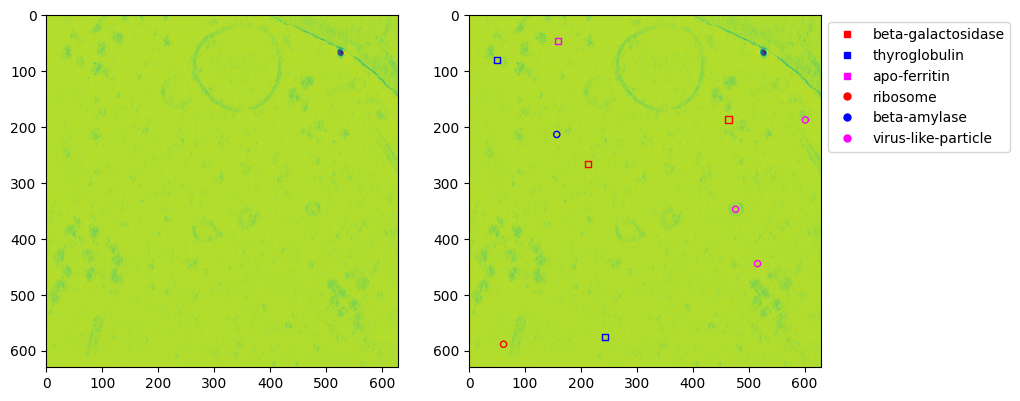

In [581]:
idx = 68
for key in hig_labels_list[idx]:
    for label, coord in zip(hig_labels_list[idx]['labels'], hig_labels_list[idx]['coord']):
        print(f"{label[0]}: {coord}", end = '; ')
mark_particle_on_image(hig_res_dataset['TS_6_4'][idx, :, :], hig_labels_list[idx])

#### Plotting 3d representation

In [582]:
# scans = np.array(low_res_dataset['TS_5_4'])
# norm = Normalize(vmin=scans.min(), vmax=scans.max())

# point_cloud = o3d.geometry.PointCloud()
# points = []
# colors = []
# c_values = [np.array(cm.viridis(scans[0][0][0])[:3])]
# for experiment_run in range(scans.shape[0]):
#     for x in range(scans.shape[1]):
#         for y in range(scans.shape[2]):
#             points.append(np.array((experiment_run, x, y)))
#             color = np.array(cm.viridis(norm(scans[experiment_run][x][y]))[:3])
#             colors.append(color)
# point_cloud.points = o3d.utility.Vector3dVector(points)
# point_cloud.colors = o3d.utility.Vector3dVector(colors)
# o3d.visualization.draw_geometries([point_cloud])

#### Plotting RGB channel for points

In [583]:
# fig = plt.figure(figsize=(10,10))
# ax = plt.subplot(3, 1, 1)
# ax.plot(np.arange(len(colors)), np.array(colors)[:, 0])
# ax = plt.subplot(3, 1, 2)
# ax.plot(np.arange(len(colors)), np.array(colors)[:, 1])
# ax = plt.subplot(3, 1, 3)
# ax.plot(np.arange(len(colors)), np.array(colors)[:, 2])

## Adding noise

In [584]:


id = 123
plt.figure(figsize=(20,20))

ax = plt.subplot(2, 2, 1)
ax.title.set_text("undistorted")
plt.imshow(hig_imgs_list[id])

ax = plt.subplot(2, 2, 2)
ax.title.set_text("gauss")
mean = np.array(hig_imgs_list).mean() 
std = np.array(hig_imgs_list).std()
gauss = add_gaussian_noise(hig_imgs_list[id], mean=mean, std=std)
plt.imshow(gauss)

ax = plt.subplot(2, 2, 3)
ax.title.set_text("salt and pepper")
salt_pepper = add_salt_pepper_noise(hig_imgs_list[id])
plt.imshow(salt_pepper)

ax = plt.subplot(2, 2, 4)
ax.title.set_text("speckle")
speckle = add_speckle_noise(hig_imgs_list[id])
plt.imshow(speckle)

plt.show()


## Creating dataset

In [1]:
class cell_database(Dataset):
    def __init__(self, imgs, hits, gauss_p=0.8, s_and_p_p=0.8, speckle_p=0.8):
        self.xs = []
        self.ys = []
        all_imgs = np.concatenate([np.array(img).flatten() for img in imgs])
        min_value = all_imgs.min()
        max_value = all_imgs.max()
        for img, hit in zip(imgs, hits):
            if len(hit['boxes']) == 0:
                continue
            x = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) # we add a dimension to "simulate" color channels
            x = (x - min_value) / (max_value - min_value + 1e-10)
            self.xs.append(x) 
            

            labels = torch.tensor([label_to_int[label] for label in hit['labels']], dtype=torch.int64)
            boxes = torch.tensor(hit['boxes'], dtype=torch.float32)
            y = {'labels': labels, 'boxes': boxes}
            self.ys.append(y)
           
            # DATA AUGMENTATION
            if np.random.rand() < gauss_p:
                noisy = torch.tensor(self.add_gaussian_noise(x[0], all_imgs.mean(), all_imgs.std()), dtype=torch.float32).unsqueeze(0)
                noisy = (noisy - min_value) / (max_value - min_value + 1e-10)
                self.xs.append(noisy)
                self.ys.append(y)
            if np.random.rand() < s_and_p_p:
                noisy = torch.tensor(self.add_salt_pepper_noise(x[0]), dtype=torch.float32).unsqueeze(0)
                noisy = (noisy - min_value) / (max_value - min_value + 1e-10)
                self.xs.append(noisy)
                self.ys.append(y)
            if np.random.rand() < speckle_p:
                noisy = torch.tensor(self.add_speckle_noise(x[0]), dtype=torch.float32).unsqueeze(0)
                noisy = (noisy - min_value) / (max_value - min_value + 1e-10)
                self.xs.append(noisy)
                self.ys.append(y)

    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        y = self.ys[idx]
        x = self.xs[idx]
        return x, y

    @staticmethod
    def add_gaussian_noise(image, mean, std):
        return image + np.random.normal(mean, std, image.shape)
    
    @staticmethod
    def add_salt_pepper_noise(image, prob=0.01):
        noisy = copy.deepcopy(image)
        noisy = np.array(noisy)
        noise_prob = np.random.rand(noisy.shape[0], noisy.shape[1])
        noisy[noise_prob < prob / 2] = noisy.min()  # Pepper (black)
        noisy[noise_prob > 1 - prob / 2] = noisy.max()  # Salt (white)
        return noisy

    @staticmethod
    def add_speckle_noise(image, std=0.2):
        img = copy.deepcopy(image)
        img = np.array(img)
        noise = np.random.normal(0, std, img.shape)
        return img + img * noise

NameError: name 'Dataset' is not defined

## Set up dataloader

In [630]:
# Load dataset
dataset = CZII_Dataset(hig_imgs_list, hig_labels_list)
dataset1 = CZII_Dataset(hig_imgs_list, hig_labels_list, gauss_p=0, s_and_p_p=0, speckle_p=0)
# Create data loaders
print(len(dataset.xs))
print(len(dataset.ys))
print(len(dataset1.xs))
print(len(dataset1.ys))

In [639]:
data_loader = DataLoader(dataset, batch_size=4, num_workers=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

## Load pretrained faster r-cnn

In [640]:
# Load the pre-trained Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(weights=None)

# Number of classes (your dataset classes + 1 for background)
num_classes = 7  # For example, 2 classes + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the head of the model with a new one (for the number of classes in your dataset)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## Training loop

In [646]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.0, weight_decay=0.0005)
# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
   # Training loop
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        # Backward pass
        losses.backward()
        optimizer.step()
        train_loss += losses.item()

    # Update the learning rate
    lr_scheduler.step()
    print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {train_loss / len(data_loader)}')
print("Training complete!")

## Evaluate the model

In [647]:
model.eval()
# Test on a new image
id = 0
good = None
with torch.no_grad():
    for img, _ in data_loader:
        img = dataset.xs[id].to(device)
        predictions = model([img])
        if predictions[0]['boxes'].shape[0] > 0:
            good = predictions
            break
        id += 1
if good is None:
    print("No hit")
else:
    print(id, len(predictions[0]['boxes']))



In [648]:
def gen_hit(y):
    hit = {'coord': [], 'labels': []}
    int_to_label = ['beta-galactosidase', 'thyroglobulin', 'apo-ferritin', 'ribosome', 'beta-amylase', 'virus-like-particle']
    for i, box in enumerate(y['boxes']):
        hit['labels'].append(int_to_label[y['labels'][i] - 1])
        hit['coord'].append(np.array(box[:2].cpu()))
    return hit

## Prediction from model

In [649]:
hit = gen_hit(good[0])
mark_particle_on_image(dataset.xs[id][0], hit)

## Actual particles

In [645]:
mark_particle_on_image(dataset.xs[id][0],  gen_hit(dataset.ys[id]))
print(dataset.ys[id]['labels'])